# Setup

In [1]:
# Install necessary packages
!pip install opendatasets

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# For reading the dataset from Kaggle
import opendatasets as od
import pandas

# For reading the image file paths from the "Files" tab
import os

# For getting the actual images from "Files" tab, from a file path
import PIL
from PIL import Image

# For specifying variable types
from typing import Tuple

In [15]:
# Set the random seed
np.random.seed(42)

# Define some variables
labels = (0, 1, 2, 3, 4, 5, 6, 7)
label_strings = ("airplane", "car", "cat", "dog", "flower", "fruit", "motorbike", "person")
label_count = len(labels)
epoch_amount = 5
batch_size = 128

# Data setup

In [4]:
# Load the dataset from Kaggle


# Download Kaggle API token key from the Kaggle website while logged into your account
# Use this key to login when running this code block
dataset_path = "https://www.kaggle.com/datasets/prasunroy/natural-images"
od.download(dataset_path)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kevinkubota
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/prasunroy/natural-images


100%|██████████| 342M/342M [00:03<00:00, 98.9MB/s]


In [5]:
# Retrieves the data


# Returns the images and labels of all examples in the dataset
def load_dataset(dataset_directory: str):# -> Tuple[PIL.JpegImagePlugin.JpegImageFile, str]:
  x_temp, y_temp = [], []
  # Traverse through the directory
  for root, directories, files in os.walk(dataset_directory):
    for filename in files:
      # Join the strings to get the file's full path
      filepath = os.path.join(root, filename)
      for label in labels:
        # An example is labeled if its file path contains the label in its name
        if label_strings[label] in filename:
          x_temp.append(Image.open(filepath))
          y_temp.append(label)
  return x_temp, y_temp


natural_dataset_path = "natural-images/data/natural_images"
x_raw, y_raw = load_dataset(natural_dataset_path)
if len(x_raw) != len(y_raw):
  Exception("x train and y train have unequal sizes")
m = len(x_raw)

In [6]:
# Prepares the data before splitting it into training, validation, and test sets


# Returns the average dimension size of the entire dataset
def get_average_image_size(images):
  avg_height = 0
  avg_width = 0
  for image in images:
    avg_height += image.height
    avg_width += image.width
  avg_height /= m
  avg_width /= m
  avg_height = int(avg_height)
  avg_width = int(avg_width)
  return avg_height, avg_width


# Resizes all dataset images to be the same size
def resize_images(images, new_size):
  for i in range(len(images)):
    images[i] = images[i].resize(new_size)
  return images


avg_size = get_average_image_size(x_raw)
x_resized = resize_images(x_raw, avg_size)

In [7]:
# Starts splitting up the data


'''
For reference, output from HW 3 for set shapes
x train all  (60000, 28, 28)
y train all  (60000,)
x train  (55000, 28, 28)
y train  (55000,)
x dev  (5000, 28, 28)
y dev  (5000,)
x test  (10000, 28, 28)
y test  (10000,)
'''

# Maybe also try np.asarray and np.copy
x_train_all = np.array(x_resized)
y_train_all = np.array(y_raw)

# Another working way to split the datasets
# twenty_percent_split = int(m * 0.2)
# x_test = x_train_all[:twenty_percent_split]
# y_test = y_train_all[:twenty_percent_split]
# x_dev = x_train_all[twenty_percent_split:2 * twenty_percent_split]
# y_dev = y_train_all[twenty_percent_split:2 * twenty_percent_split]
# x_train = x_train_all[2 * twenty_percent_split:]
# y_train = y_train_all[2 * twenty_percent_split:]

# Split the datasets
# 60% training, 40% testing
x_train, x_test_all, y_train, y_test_all = train_test_split(x_train_all, y_train_all, test_size = 0.4, random_state = 42)
# From the 40% testing, it gets split into 20% validation and 20% (actual) testing
x_dev, x_test, y_dev, y_test = train_test_split(x_test_all, y_test_all, test_size = 0.5, random_state = 42)

x train all shape =  (6899, 234, 198, 3)
y train all shape =  (6899,)
x test shape =  (1380, 234, 198, 3)
y test shape =  (1380,)
x dev shape =  (1380, 234, 198, 3)
y dev shape =  (1380,)
x train shape =  (4139, 234, 198, 3)
y train shape =  (4139,)


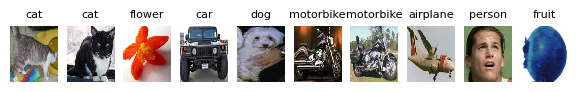

In [8]:
# Verify the datasets are split correctly


print("x train all shape = ", x_train_all.shape)
print("y train all shape = ", y_train_all.shape)
print("x test shape = ", x_test.shape)
print("y test shape = ", y_test.shape)
print("x dev shape = ", x_dev.shape)
print("y dev shape = ", y_dev.shape)
print("x train shape = ", x_train.shape)
print("y train shape = ", y_train.shape)


# Get subsets of the training dataset to show
x_sub, y_sub = [], []
sub_amount = 10
set_division_factor = int(m / sub_amount)
for i in range(sub_amount):
  x_sub.append(x_train_all[i * set_division_factor])
  y_sub.append(y_train_all[i * set_division_factor])

# Show each image and label in the subsets
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(x_sub):
    plt.subplot(1, sub_amount, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(label_strings[y_sub[index]], fontsize=8)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Model

In [16]:
# Builds the CNN model


model = tf.keras.models.Sequential()
# 3 = RGB channels
model_input_shape = [avg_size[1], avg_size[0], 3]

# Add the first convolutional layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = "relu",
                                 input_shape = model_input_shape))
# Add a pooling layer
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# Add another convolutional layer
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"))
# Add another pooling layer
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# Add another convolutional layer
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation = "relu"))
# Add another pooling layer
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
# Flatten the tensor output from the convolutional layers
model.add(tf.keras.layers.Flatten())
# Add a dense layer
model.add(tf.keras.layers.Dense(units = 64, activation = "relu"))
# Add a dropout layer
# model.add(tf.keras.layers.Dropout(0.5))
# Output layer
model.add(tf.keras.layers.Dense(units = label_count, activation = "softmax"))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 232, 196, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 116, 98, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 114, 96, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 57, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 46, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 27, 23, 128)      

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [19]:
# The model in the CNN demo exhausts the free tier Colab resources
history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epoch_amount,
    validation_data = (x_dev, y_dev))

Epoch 1/5
33/33 [==============================] - 415s 12s/step - loss: 78.1722 - accuracy: 0.3781 - val_loss: 0.8707 - val_accuracy: 0.7080
Epoch 2/5
33/33 [==============================] - 403s 12s/step - loss: 0.4986 - accuracy: 0.8302 - val_loss: 0.4358 - val_accuracy: 0.8471
Epoch 3/5
33/33 [==============================] - 391s 12s/step - loss: 0.2147 - accuracy: 0.9246 - val_loss: 0.5267 - val_accuracy: 0.8355
Epoch 4/5
33/33 [==============================] - 398s 12s/step - loss: 0.1006 - accuracy: 0.9679 - val_loss: 0.4767 - val_accuracy: 0.8659
Epoch 5/5
33/33 [==============================] - 389s 12s/step - loss: 0.0416 - accuracy: 0.9867 - val_loss: 0.4925 - val_accuracy: 0.8725


# Model Evaluation

In [26]:
# Prints loss and accuracy of the model's predictions


y_evaluations = model.evaluate(x = x_test, y = y_test)
print("Total loss =", y_evaluations[0])
print("Total accuracy =", y_evaluations[1])

44/44 [==============================] - 36s 820ms/step - loss: 0.6229 - accuracy: 0.8522
Total loss = 0.6229231953620911
Total accuracy = 0.852173924446106


In [27]:
# Try predicting using the test set


y_probabilities = model.predict(
    x = x_test,
    batch_size = batch_size
)

# Converts the arrays of probabilities (for each image being each label) to the actual labels
y_predictions = np.argmax(y_probabilities, axis = 1)

11/11 [==============================] - 36s 3s/step


In [36]:
print("Predictions =", np.array(label_strings)[y_predictions])
print("Actual =", np.array(label_strings)[y_test])

Predictions = ['dog' 'fruit' 'person' ... 'car' 'person' 'fruit']
Actual = ['cat' 'fruit' 'dog' ... 'car' 'person' 'fruit']


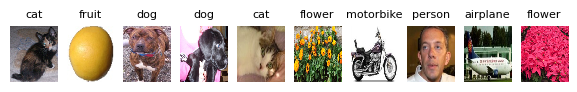

In [37]:
# Show predictions made


sub_test_amount = 10
x_sub = x_test[:sub_test_amount]
y_sub = y_test[:sub_test_amount]

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(x_sub):
    plt.subplot(1, sub_test_amount, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(label_strings[y_sub[index]], fontsize=8)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()